<span style='font-size:large'>**Problem Set 3 \(Group Activity\)**</span>

**Leader:** 

**Manansala, Richard M.**

**Members:**

**Dalugdugan, Nicko R.**

**Hilario, Franniel Luigi C.**

**Magbanua, Brian Gabriel G.**

**Pasamba, Jermaine C.**

**Ventura, Fiona C.**



In [4]:
import itertools
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [5]:
# For reproducibility
test_seed = 42
random.seed(test_seed)
np.random.seed(test_seed)

# Generate 10 random city coordinates within a 100x100 grid
NUM_CITIES = 10
cities = {f"C{i}": (random.uniform(0, 100), random.uniform(0, 100)) for i in range(NUM_CITIES)}

# Distance function
def distance(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])

# Precompute distance matrix
distances = {u: {v: distance(cities[u], cities[v]) for v in cities} for u in cities}

def tour_length(path):
    return sum(distances[path[i]][path[(i+1) % len(path)]] for i in range(len(path)))

<span style='font-size:x-large'>**Random sample of 10 cities**</span>


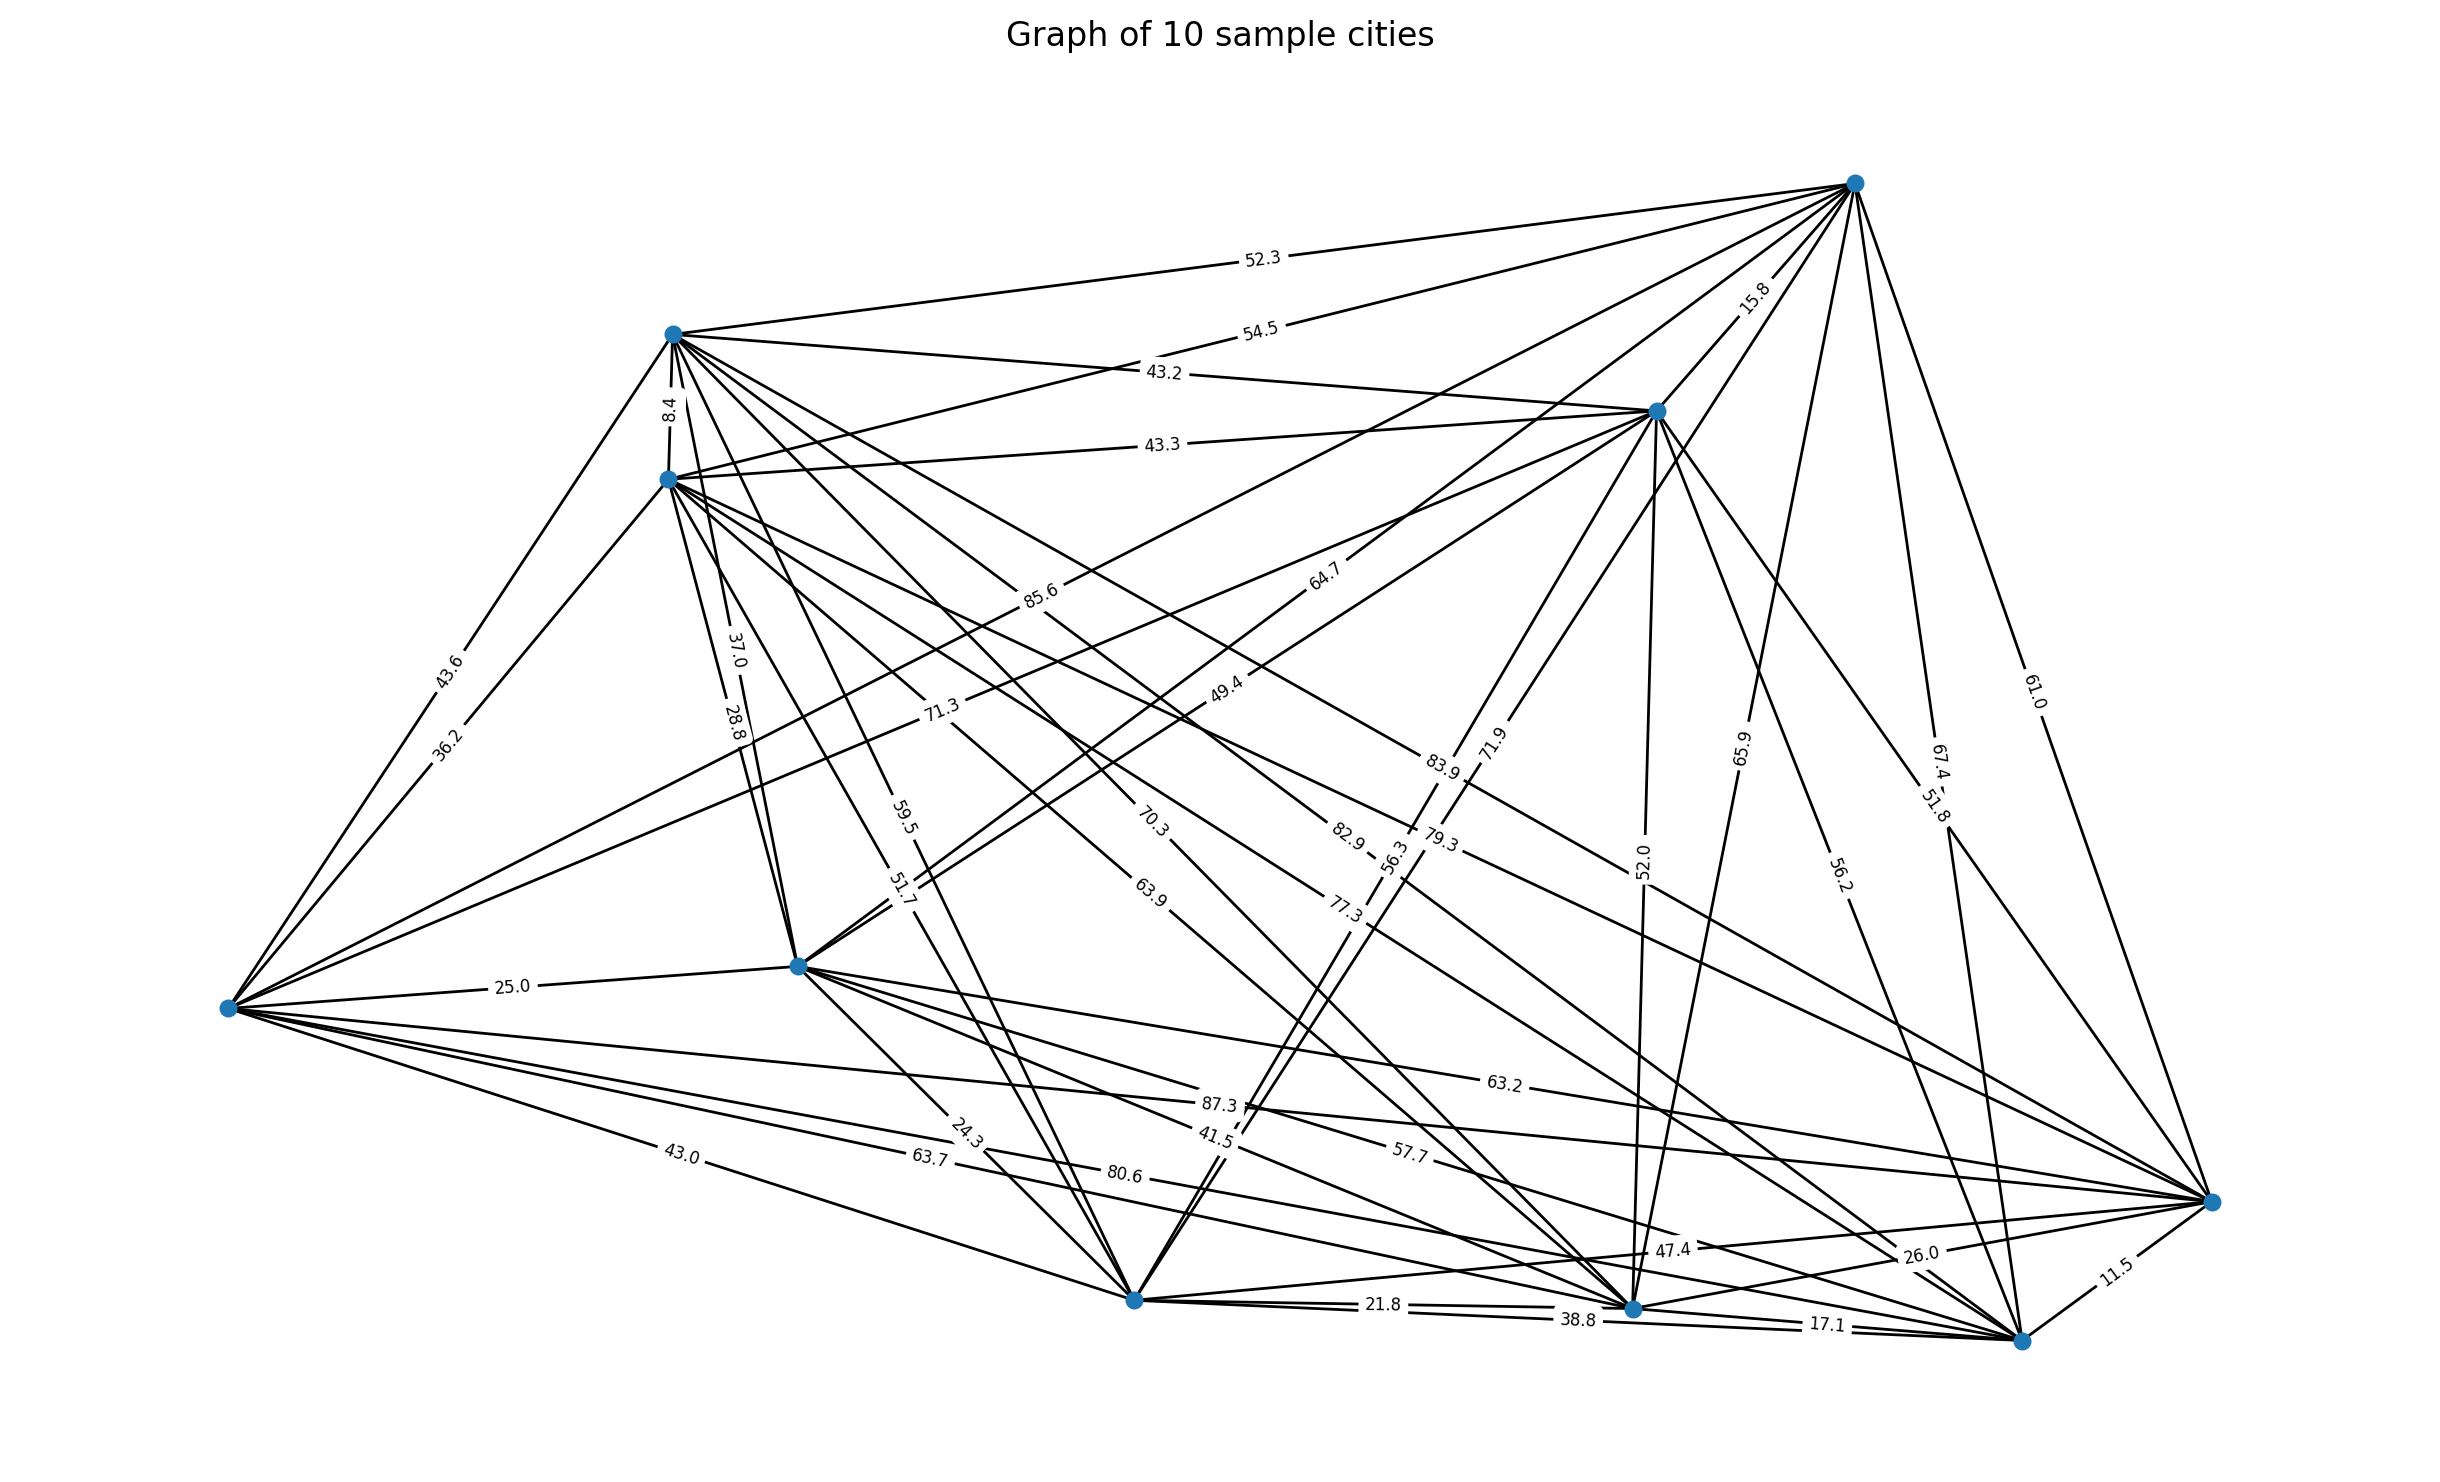

In [6]:
G = nx.Graph()
G.add_nodes_from(cities)
for u,v in itertools.combinations(cities,2):
    G.add_edge(u,v, weight=round(distances[u][v],1))
pos = {c: cities[c] for c in cities}

nx.draw(G, pos, with_labels=False, node_size=30)
edgelabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels,font_size=6)
plt.title('Graph of 10 sample cities')
plt.axis('off'); plt.show()

<span style='font-size:x-large'>**Exact Algorithm \(Brute Force\)**</span>


In [21]:
#Brute FORCE
start = time.time()
best_length = float('inf')
best_path = None
for perm in itertools.permutations(cities):
    length = sum(distances[perm[i]][perm[(i+1)%len(cities)]] for i in range(len(cities)))
    if length < best_length:
        best_length = length
        best_path = perm
brute_time = time.time() - start

# Create a DataFrame to display results
brute_results_df = pd.DataFrame({
    'Best Path': [best_path],
    'Tour Length': [best_length],
    'Time (s)': [brute_time]
})

# Style DataFrame for better display in Jupyter Notebook
styled_brute_results_df = brute_results_df.style \
    .format({'Tour Length': '{:.2f}', 'Time (s)': '{:.4f}'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f4cccc'), ('color', '#000'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fde8ef')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#fef6f9')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#f9d5e5')]}
    ]) \
    .set_properties(**{'border': '1px solid #e0e0e0'})

# Display styled DataFrame
display(styled_brute_results_df)

print(f"Brute Force → Length: {best_length:.2f}, Time: {brute_time:.4f}s")


,Best Path,Tour Length,Time (s)
0,"('C0', 'C4', 'C1', 'C6', 'C5', 'C8', 'C2', 'C7', 'C3', 'C9')",264.14,9.7385


Brute Force → Length: 264.14, Time: 9.7385s


<span style='font-size:x-large'>**Greedy Heuristic \(Nearest Neighbor\)**</span>


In [20]:
#Nearest Neighbor
def nearest_neighbor(cities):
    # Implements the nearest neighbor heuristic for TSP.
    # Starts at a random city and repeatedly visits the nearest unvisited city.

    # Track unvisited cities
    unvisited = set(cities)  
    
    # Start at random city
    current = random.choice(list(unvisited))  
    
    path = [current]
    unvisited.remove(current)
    
    while unvisited:
        # Find nearest unvisited city using distance matrix
        nearest = min(unvisited, key=lambda city: distances[current][city])
        path.append(nearest)
        unvisited.remove(nearest)
        
        # Move to the nearest city                 
        current = nearest  
    
    return path

# Time and run the algorithm
start = time.time()
nn_path = nearest_neighbor(cities)
nn_length = tour_length(nn_path)
nn_time = time.time() - start

# Create a DataFrame to display the results
nn_results_df = pd.DataFrame({
    'Nearest Neighbor Path': [nn_path],
    'Tour Length': [nn_length],
    'Time (s)': [nn_time]
})

# Style the DataFrame for pleasant display in Jupyter Notebook
styled_nn_results_df = nn_results_df.style \
    .format({'Tour Length': '{:.2f}', 'Time (s)': '{:.4f}'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f4cccc'), ('color', '#000'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fde8ef')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#fef6f9')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#f9d5e5')]}
    ]) \
    .set_properties(**{'border': '1px solid #e0e0e0'})

# Display the styled DataFrame
display(styled_nn_results_df)

print(f"Nearest Neighbor → Length: {nn_length:.2f}, Time: {nn_time:.4f}s")


,Nearest Neighbor Path,Tour Length,Time (s)
0,"['C3', 'C9', 'C0', 'C4', 'C1', 'C6', 'C5', 'C8', 'C7', 'C2']",264.16,0.0001


Nearest Neighbor → Length: 264.16, Time: 0.0001s


<span style='font-size:x-large'>**Genetic Algorithm**</span>


In [16]:
#Genetic Algorithm
# Parameters
POP_SIZE = 100
GENERATIONS = 500
MUTATION_RATE = 0.01

# Genetic Algorithm components for TSP

# Create a random permutation of cities (individual/solution).
def create_individual():
    individual = list(cities.keys())
    random.shuffle(individual)
    return individual

# Calculate fitness as inverse of tour length (shorter = better).
def population_fitness(population):
    return [1/tour_length(ind) for ind in population]

# Select parents using fitness-proportional selection.
def select_parents(population, fitness):
    return random.choices(population, weights=fitness, k=2)

# Ordered crossover for TSP (preserves city order from parents).
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))  # Random segment
    child = [None]*size
    
    # Copy segment from parent1
    child[start:end] = parent1[start:end]
    
    # Fill remaining from parent2 in order, skipping duplicates
    remaining = [item for item in parent2 if item not in child[start:end]]
    ptr = 0
    for i in range(size):
        if child[i] is None:
            child[i] = remaining[ptr]
            ptr += 1
    return child

# Swap mutation with given probability.
def mutate(individual):
    if random.random() < MUTATION_RATE:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

# Initialize population
population = [create_individual() for _ in range(POP_SIZE)]

start = time.time()
# Evolution loop
for _ in range(GENERATIONS):
    fitness = population_fitness(population)
    new_population = []
    
    # Create new generation
    for _ in range(POP_SIZE//2):
        parent1, parent2 = select_parents(population, fitness)
        child1 = mutate(crossover(parent1, parent2))
        child2 = mutate(crossover(parent2, parent1))
        new_population.extend([child1, child2])
    
    population = new_population

# Find best solution
best_individual = min(population, key=tour_length)
ga_length = tour_length(best_individual)
ga_time = time.time() - start

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Best Individual': [best_individual],
    'Tour Length': [ga_length],
    'Time (s)': [ga_time]
})

# Style the DataFrame for pleasant display in Jupyter Notebook
styled_results_df = results_df.style \
    .format({'Tour Length': '{:.2f}', 'Time (s)': '{:.4f}'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f4cccc'), ('color', '#000'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fde8ef')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#fef6f9')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#f9d5e5')]}
    ]) \
    .set_properties(**{'border': '1px solid #e0e0e0'})

# Display the styled DataFrame
display(styled_results_df)

print(f"Genetic Algorithm → Length: {ga_length:.2f}, Time: {ga_time:.4f}s")


,Best Individual,Tour Length,Time (s)
0,"['C3', 'C0', 'C9', 'C4', 'C1', 'C6', 'C5', 'C8', 'C7', 'C2']",295.70,0.8534


Genetic Algorithm → Length: 295.70, Time: 0.8534s


<span style='font-size:x-large'>**Comparison Table of Results**</span>


,Algorithm,Distance,Time (s)
0,Brute Force,264.14,9.3907
1,Nearest Neighbor,264.14,0.0001
2,Genetic Algorithm,295.70,0.8534


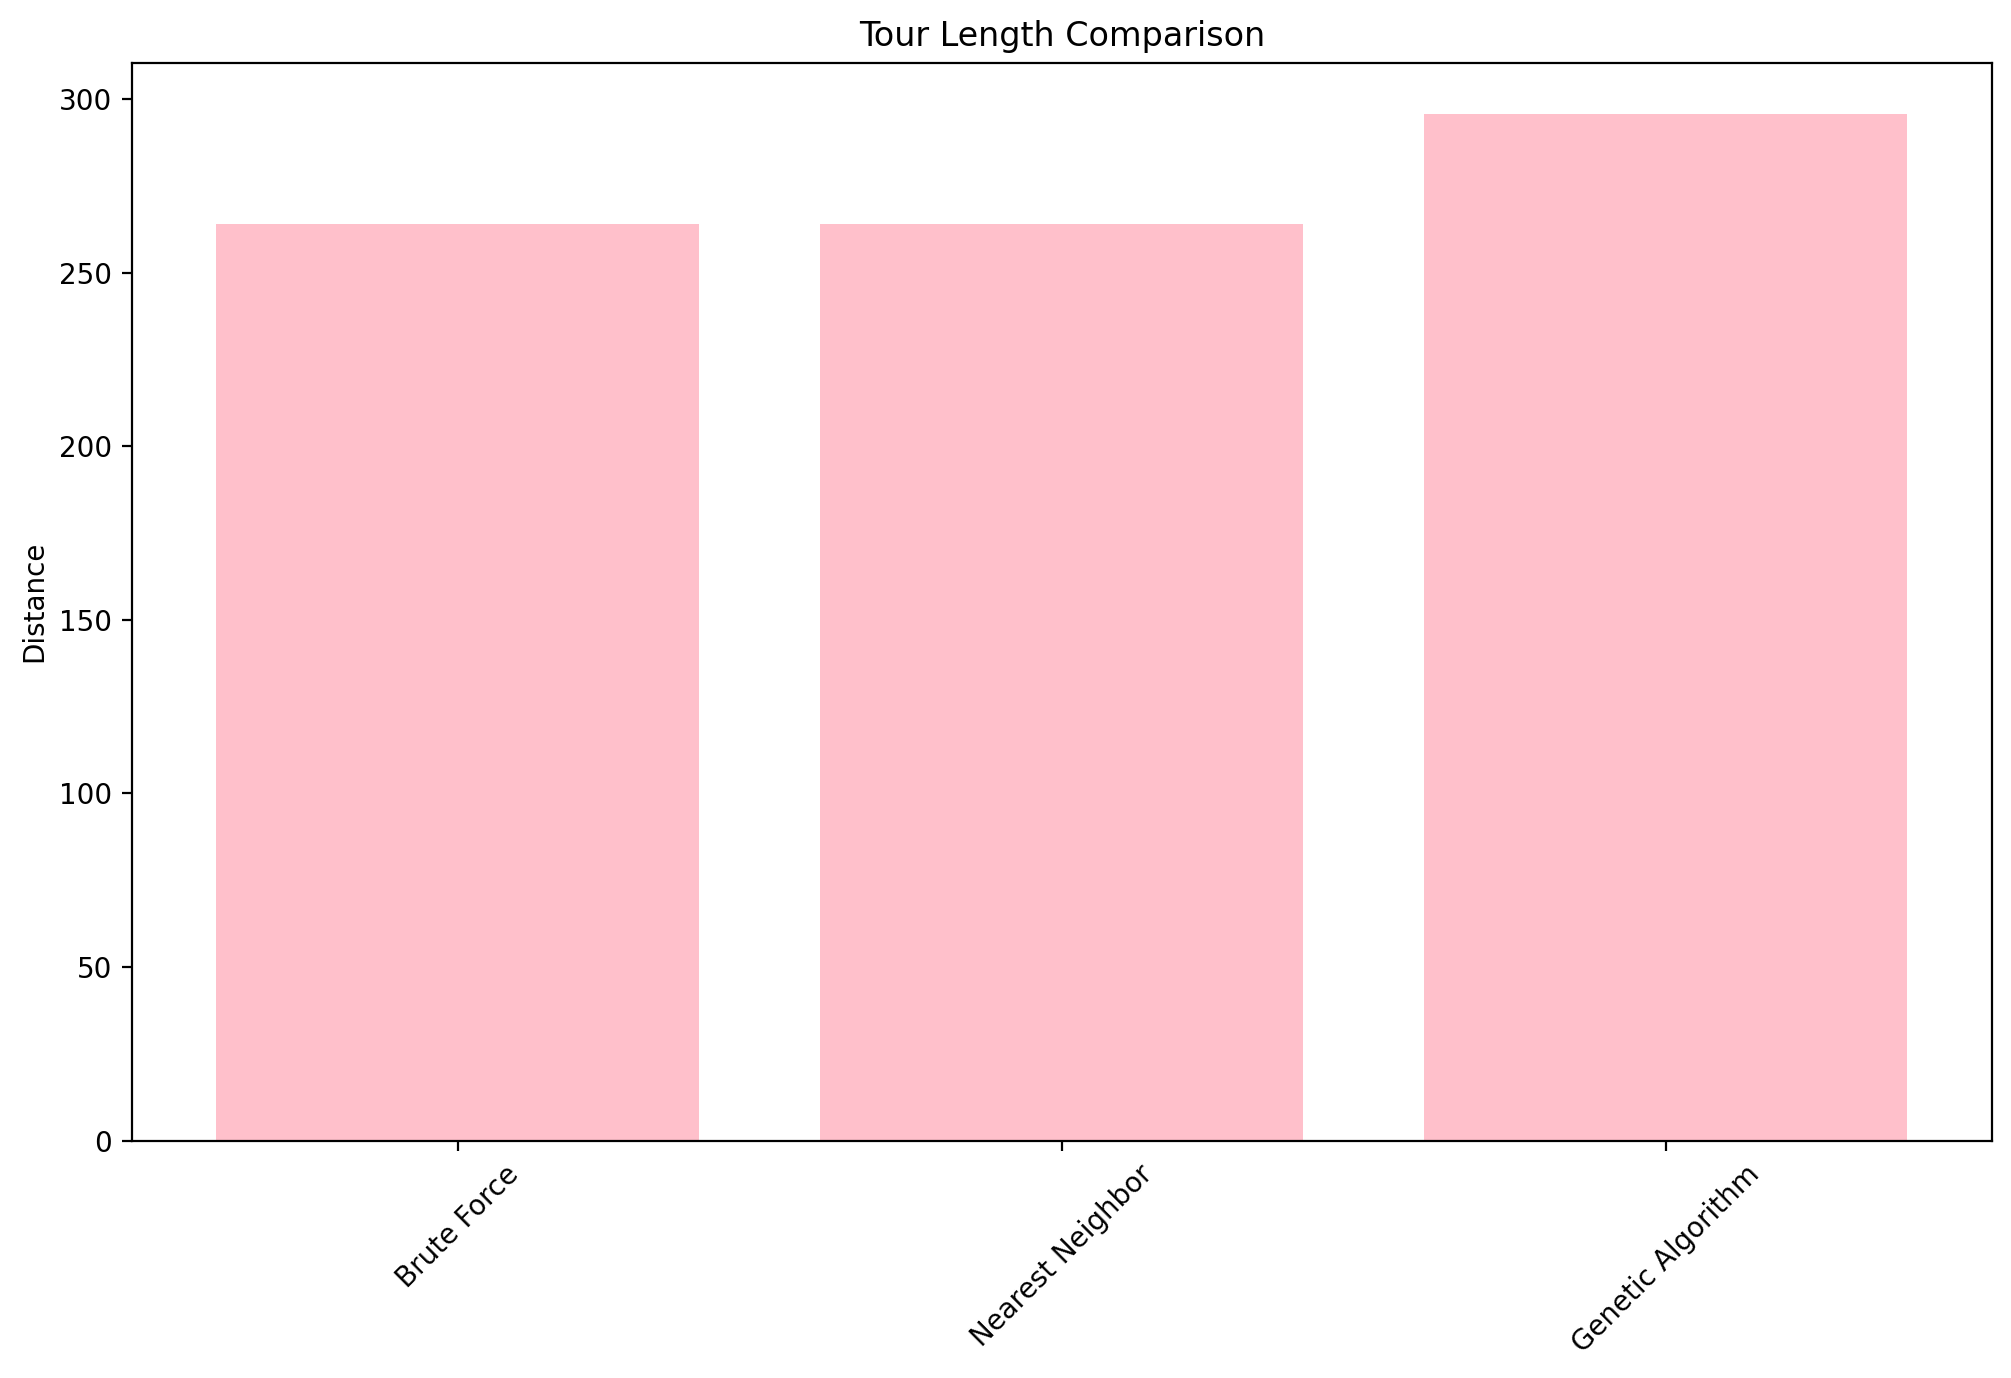

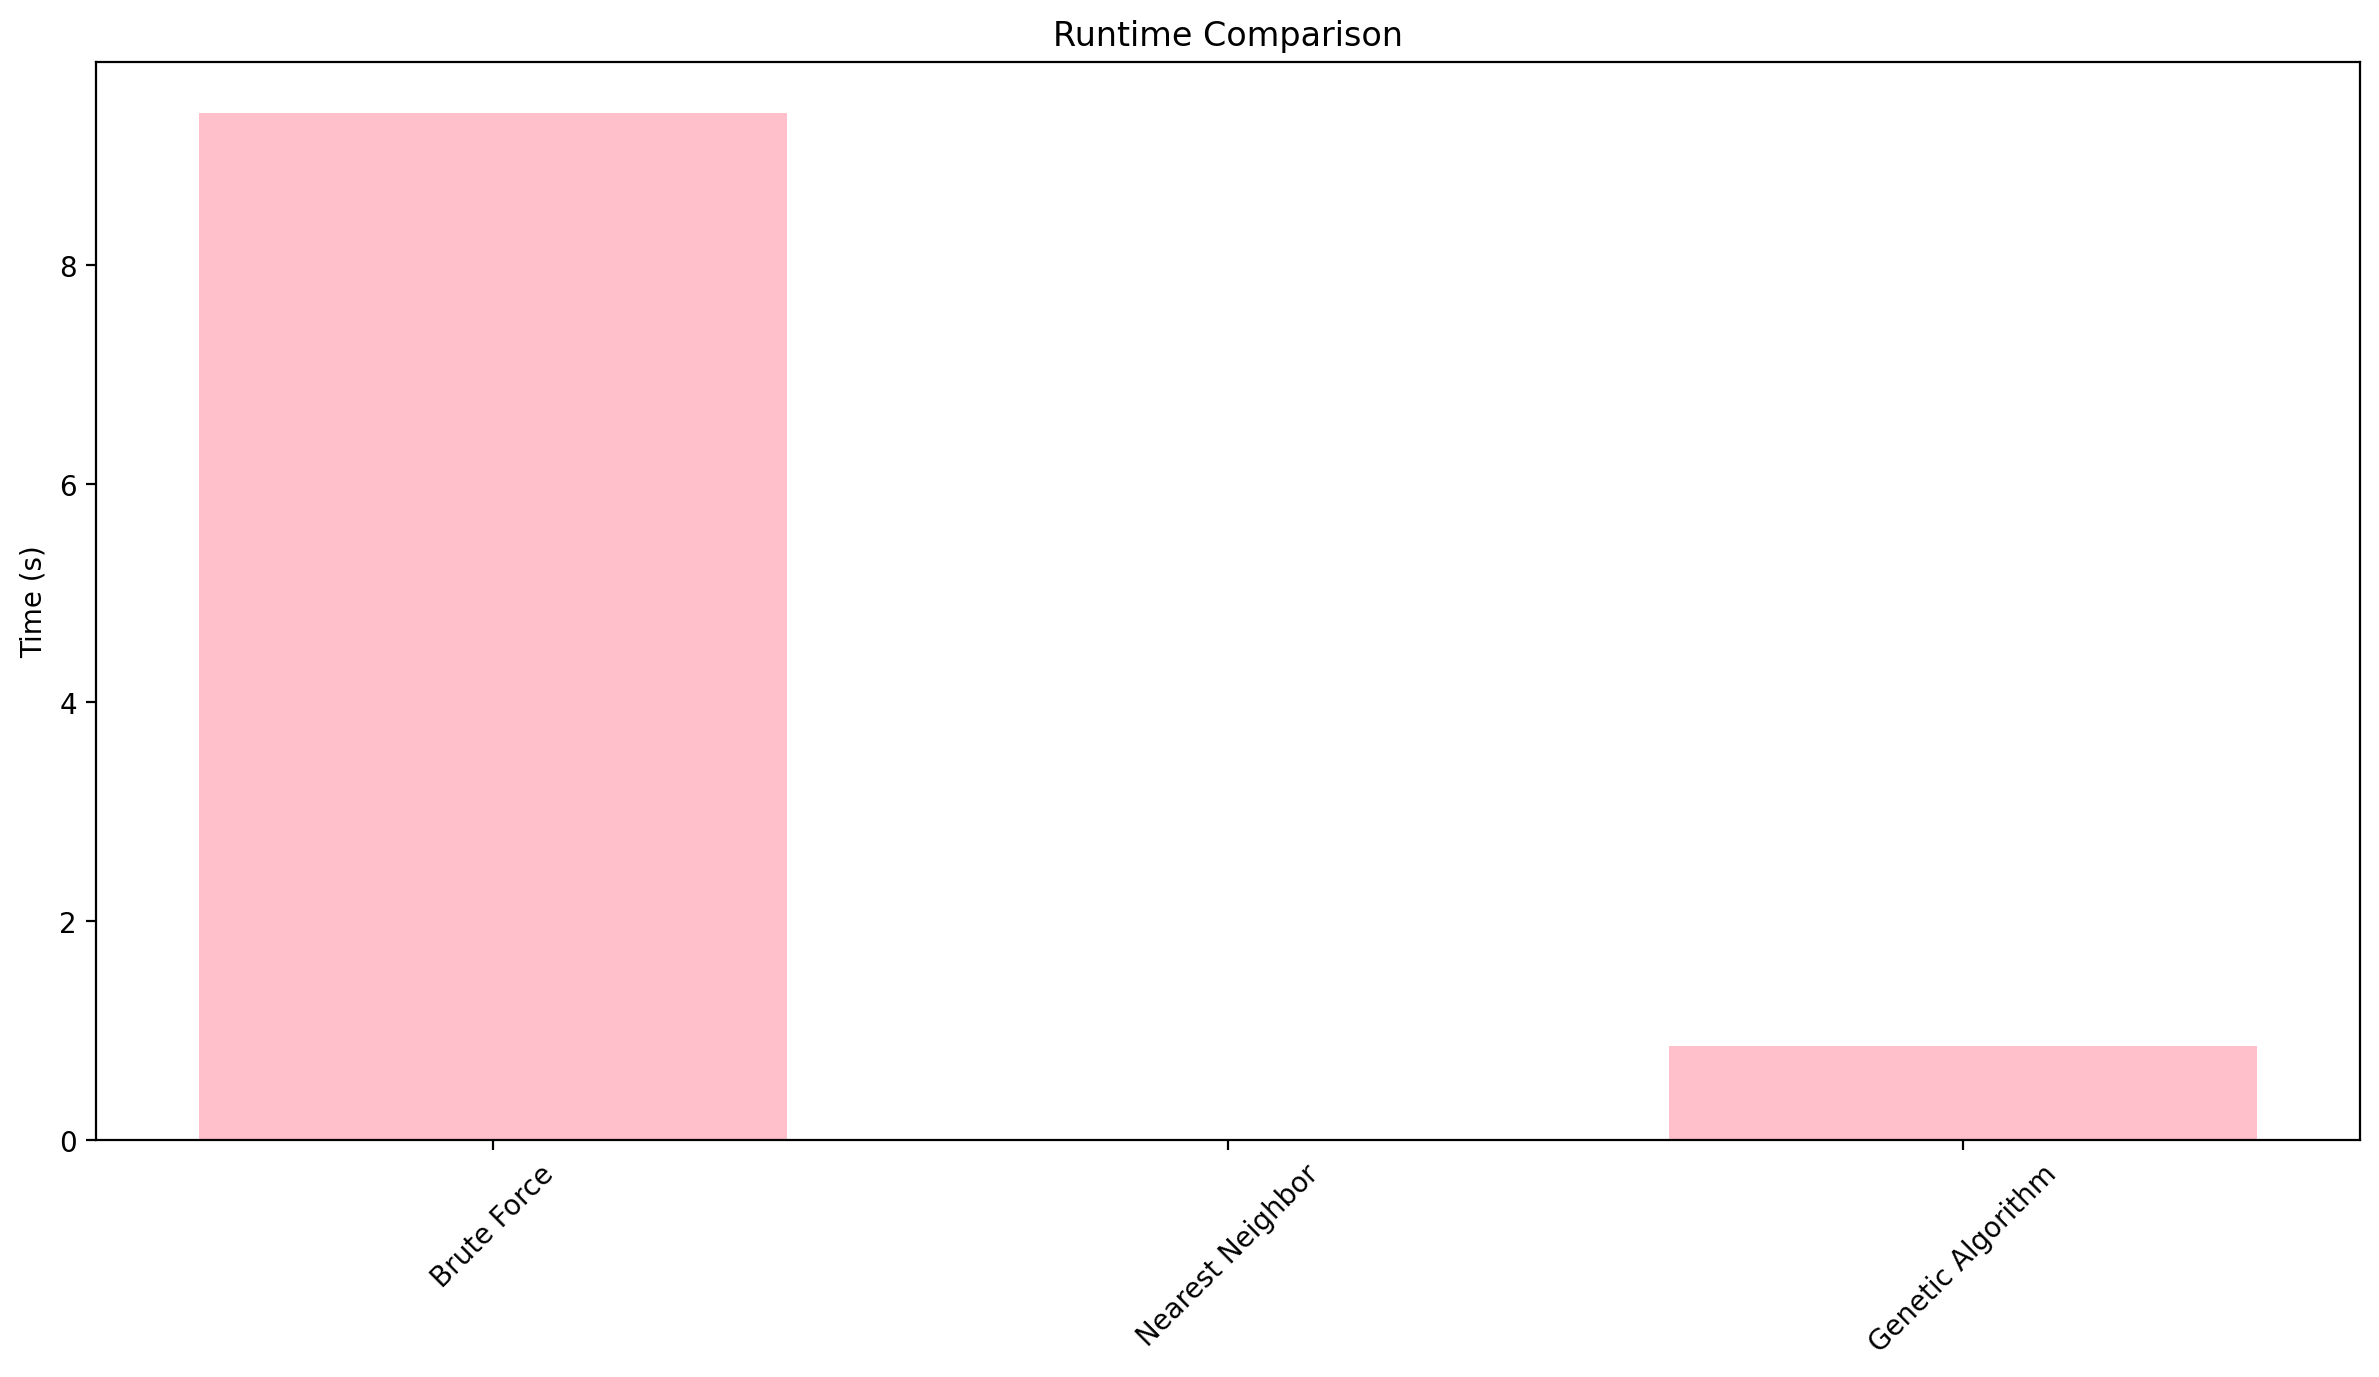

In [17]:


results = [
    ('Brute Force', best_length, brute_time),
    ('Nearest Neighbor', nn_length, nn_time),
    ('Genetic Algorithm', ga_length, ga_time)
]

# Create DataFrame from results
df = pd.DataFrame(results, columns=['Algorithm', 'Distance', 'Time (s)'])

# Style the DataFrame for pleasant display in Jupyter Notebook
styled_df = df.style \
    .format({'Distance': '{:.2f}', 'Time (s)': '{:.4f}'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f4cccc'), ('color', '#000'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '8px')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fde8ef')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#fef6f9')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#f9d5e5')]}
    ]) \
    .set_properties(**{'border': '1px solid #e0e0e0'})

display(styled_df)

# Charts
labels = df['Algorithm'].tolist()
distances_cmp = df['Distance'].tolist()
times_cmp = df['Time (s)'].tolist()

plt.figure()
plt.bar(labels, distances_cmp, color='pink')
plt.title('Tour Length Distance Comparison')
plt.ylabel('Distance')
plt.xticks(rotation=45)

plt.figure()
plt.bar(labels, times_cmp, color='pink')
plt.title('Runtime per second Comparison')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<span style='font-size:medium'>**Tour Length Distance Comparison Bar Chart:**</span>

The graphs above illustrate the two main factors we looked at when selecting the best and most efficient algorithm. The Tour Length Comparison Bar Chart displays the total distance each algorithm traveled to visit all 10 randomly generated cities. In this chart, the algorithm with the shortest distance is deemed the best based on this criterion. It's important to highlight that the Brute Force method always finds the shortest distance because it examines all possible routes—specifically, 10! or 3,628,800 different paths—and selects the best one. Besides the Brute Force method, both the Genetic Algorithm and Ant Colony methods also achieved the same distance as the Brute Force method, making them the top contenders in this category as well.

<span style='font-size:medium'>**Runtime per second Comparison Bar Chart:**</span>

The Runtime Comparison Bar Chart records the total time each algorithm took to find the best route, considering the time complexity of O\(10!\). This allows us to compare the efficiency of the algorithms. As expected from the Tour Length Comparison Bar Chart, the Brute Force method consistently shows the longest runtime since it evaluates every possible route. In contrast, the Nearest Neighbor algorithm completes its task very quickly, making it the most efficient algorithm in this aspect.

